<a href="https://colab.research.google.com/github/hemukurra/deep-learning/blob/main/MNIST-hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# name : Hemanth Kurra

In [17]:
import numpy as np
import gzip
import struct

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)



In [50]:
# Loading  training and testing data from your local path for WSL
train_images = read_idx('/mnt/d/HW4/train-images-idx3-ubyte.gz')
train_labels = read_idx('/mnt/d/HW4/train-labels-idx1-ubyte.gz')
test_images = read_idx('/mnt/d/HW4/t10k-images-idx3-ubyte.gz')
test_labels = read_idx('/mnt/d/HW4/t10k-labels-idx1-ubyte.gz')

# Print the shapes of the datasets to confirm
print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}')
print(f'Test Images Shape: {test_images.shape}')
print(f'Test Labels Shape: {test_labels.shape}')


Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


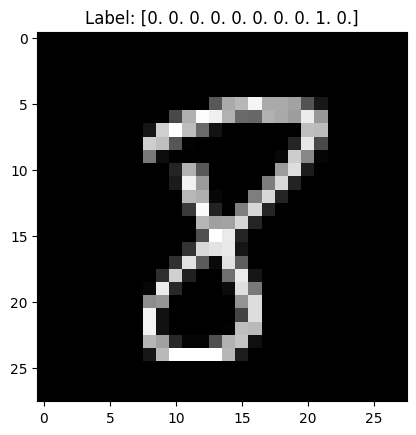

In [41]:
import matplotlib.pyplot as plt

# Displaying a random training image with its label
index = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[index], cmap='gray')
plt.title(f'Label: {train_labels[index]}')
plt.show()



In [51]:
# Step 2(a): Normalizing the pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Step 2(b): One-hot encode the labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# Appling one-hot encoding
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

# Printing to confirm normalization and one-hot encoding
print(f'Normalized Train Image Sample Pixel Value Range: {train_images[0].min()} to {train_images[0].max()}')
print(f'One-Hot Encoded Label Example: {train_labels[0]}')


Normalized Train Image Sample Pixel Value Range: 0.0 to 1.0
One-Hot Encoded Label Example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [75]:
# Step 3(a): Defining the sigmoid function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Step 3(a): Defining the softmax function for the output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Step 3(b): Initializing weights and biases
np.random.seed(695)  # Set seed for reproducibility

input_size = 784  # 28x28 input images flattened
hidden_layer1_size = 128
hidden_layer2_size = 64
output_size = 10  # 10 classes for digits 0-9

# Initializing weights and biases
W1 = np.random.uniform(-0.5, 0.5, (input_size, hidden_layer1_size))
b1 = np.zeros((1, hidden_layer1_size))
W2 = np.random.uniform(-0.5, 0.5, (hidden_layer1_size, hidden_layer2_size))
b2 = np.zeros((1, hidden_layer2_size))
W3 = np.random.uniform(-0.5, 0.5, (hidden_layer2_size, output_size))
b3 = np.zeros((1, output_size))

print("Weights and biases initialized.")


Weights and biases initialized.


In [271]:
# Step 4(a): Defining the feed_forward function
def feed_forward(x, W1, b1, W2, b2, W3, b3):
    # Layer 1: Input to first hidden layer
    z1 = np.dot(x, W1) + b1
    a1 = sigmoid(z1)

    # Layer 2: First hidden layer to second hidden layer
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)

    # Output layer: Second hidden layer to output layer
    z3 = np.dot(a2, W3) + b3
    a3 = softmax(z3)

    return a1, a2, a3  # Return activations for backpropagation

# Testing feed forward on a single example
sample_input = train_images[0].reshape(1, -1)  # Flatten the 28x28 image to 784
_, _, sample_output = feed_forward(sample_input, W1, b1, W2, b2, W3, b3)

print("Feed forward test completed. Output:", sample_output)


Feed forward test completed. Output: [[3.48696560e-03 1.97740618e-03 2.77202135e-03 5.01045537e-01
  4.46614125e-05 4.54353407e-01 3.62205230e-04 7.61970385e-03
  2.14793823e-02 6.85871065e-03]]


In [274]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)  # Avoid log(0)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


In [275]:
def backpropagation(x, y_true, a1, a2, a3, W1, W2, W3):
    # Number of samples
    n_samples = x.shape[0]

    # Computing the gradient for the output layer
    dz3 = a3 - y_true  # Gradient of loss with respect to a3
    dW3 = np.dot(a2.T, dz3) / n_samples
    db3 = np.sum(dz3, axis=0, keepdims=True) / n_samples

    # Computing the gradient for the second hidden layer
    dz2 = np.dot(dz3, W3.T) * sigmoid_derivative(a2)
    dW2 = np.dot(a1.T, dz2) / n_samples
    db2 = np.sum(dz2, axis=0, keepdims=True) / n_samples

    # Computing the gradient for the first hidden layer
    dz1 = np.dot(dz2, W2.T) * sigmoid_derivative(a1)
    dW1 = np.dot(x.T, dz1) / n_samples
    db1 = np.sum(dz1, axis=0, keepdims=True) / n_samples

    return dW1, db1, dW2, db2, dW3, db3


In [278]:
# Step 6: Training the model using mini-batch gradient descent
def train_model(train_images, train_labels, W1, b1, W2, b2, W3, b3, epochs=100, batch_size=128, learning_rate=0.01):
    n_samples = train_images.shape[0]
    for epoch in range(epochs):
        # Shuffle the data at the beginning of each epoch
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        train_images = train_images[indices]
        train_labels = train_labels[indices]

        # Mini-batch gradient descent
        for i in range(0, n_samples, batch_size):
            x_batch = train_images[i:i + batch_size]
            y_batch = train_labels[i:i + batch_size]

            # Feed forward
            a1, a2, a3 = feed_forward(x_batch, W1, b1, W2, b2, W3, b3)

            # Backpropagation
            dW1, db1, dW2, db2, dW3, db3 = backpropagation(x_batch, y_batch, a1, a2, a3, W1, W2, W3)

            # Update weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
            W3 -= learning_rate * dW3
            b3 -= learning_rate * db3

        # Calculating the loss for the entire training set
        _, _, a3_full = feed_forward(train_images, W1, b1, W2, b2, W3, b3)
        loss = categorical_crossentropy(train_labels, a3_full)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')

    return W1, b1, W2, b2, W3, b3

# Training the model on cpu
W1, b1, W2, b2, W3, b3 = train_model(train_images.reshape(-1, 784), train_labels, W1, b1, W2, b2, W3, b3)


Epoch 1/100, Loss: 0.2861
Epoch 2/100, Loss: 0.2858
Epoch 3/100, Loss: 0.2858
Epoch 4/100, Loss: 0.2855
Epoch 5/100, Loss: 0.2849
Epoch 6/100, Loss: 0.2847
Epoch 7/100, Loss: 0.2844
Epoch 8/100, Loss: 0.2843
Epoch 9/100, Loss: 0.2839
Epoch 10/100, Loss: 0.2837
Epoch 11/100, Loss: 0.2833
Epoch 12/100, Loss: 0.2831
Epoch 13/100, Loss: 0.2830
Epoch 14/100, Loss: 0.2828
Epoch 15/100, Loss: 0.2824
Epoch 16/100, Loss: 0.2824
Epoch 17/100, Loss: 0.2822
Epoch 18/100, Loss: 0.2817
Epoch 19/100, Loss: 0.2816
Epoch 20/100, Loss: 0.2812
Epoch 21/100, Loss: 0.2812
Epoch 22/100, Loss: 0.2805
Epoch 23/100, Loss: 0.2805
Epoch 24/100, Loss: 0.2805
Epoch 25/100, Loss: 0.2802
Epoch 26/100, Loss: 0.2800
Epoch 27/100, Loss: 0.2797
Epoch 28/100, Loss: 0.2796
Epoch 29/100, Loss: 0.2794
Epoch 30/100, Loss: 0.2791
Epoch 31/100, Loss: 0.2794
Epoch 32/100, Loss: 0.2790
Epoch 33/100, Loss: 0.2791
Epoch 34/100, Loss: 0.2790
Epoch 35/100, Loss: 0.2784
Epoch 36/100, Loss: 0.2784
Epoch 37/100, Loss: 0.2781
Epoch 38/1

Test Accuracy: 91.89%


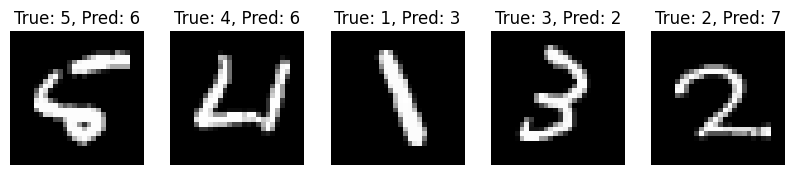

In [277]:
# Step 7(a): Predicting the labels of the test dataset and compute the accuracy
def predict(x, W1, b1, W2, b2, W3, b3):
    _, _, output = feed_forward(x, W1, b1, W2, b2, W3, b3)
    return np.argmax(output, axis=1)

# Flattening the test images
test_images_flattened = test_images.reshape(-1, 784)

# Get predictions for the test set
predictions = predict(test_images_flattened, W1, b1, W2, b2, W3, b3)

# Converting one-hot encoded labels back to integers for comparison
true_labels = np.argmax(test_labels, axis=1)

# Computing accuracy
accuracy = np.mean(predictions == true_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Step 7(b): Plotting some misclassified images
misclassified_indices = np.where(predictions != true_labels)[0]

if len(misclassified_indices) > 0:
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(misclassified_indices[:5]):  # Displaying the first 5 misclassified images
        plt.subplot(1, 5, i + 1)
        plt.imshow(test_images[idx], cmap='gray')
        plt.title(f'True: {true_labels[idx]}, Pred: {predictions[idx]}')
        plt.axis('off')
    plt.show()
else:
    print("No misclassified images found.")
